In [3]:
# worksheet for figures from "Intra-urban temperature variability in Baltimore"

# works with:
# pandas version 0.18.0
# numpy version 1.11.0
# matplotlib version 1.5.1
# import data
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import matplotlib
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 16, 12
import pandas as pd
pd.options.display.mpl_style = 'default'
get_ipython().magic(u'matplotlib inline')
import ibuttonplots
#import importibuttondata
%matplotlib inline
import cartopy.crs as ccrs
from cartopy.io.img_tiles import MapQuestOSM

# files = glob.glob('./data/*[tT].csv')
# meta0 = pd.DataFrame(pd.read_csv('./data/falldownload/TempSensorFinal_results-4.csv', sep = ','))
# #pd.DataFrame(pd.read_csv('./data/bmoremetadata.csv', sep = ','))
# tempDF0, anomalyDF0, meta0 = importibuttondata.importdata(files, meta0)

# #files = glob.glob('./data/*[tT].csv')
# files = glob.glob('./data/falldownload/*[tT].csv')
# meta1 = pd.DataFrame(pd.read_csv('./data/falldownload/TempSensorFinal_results-4.csv', sep = ','))
# #meta0 = pd.DataFrame(pd.read_csv('./data/bmoremetadata.csv', sep = ','))
# tempDF1, anomalyDF1, meta1 = importibuttondata.importdata(files, meta1)

# frames = [tempDF0, tempDF1]
# tempDF = pd.concat(frames)
# anomalyDF = pd.concat([anomalyDF0, anomalyDF1])
# meta = pd.concat([meta0, meta1.loc()[np.setdiff1d(meta1.sensornumber, meta0.sensornumber)]])

#meta = pd.DataFrame(pd.read_csv('./data/falldownload/TempSensorFinal_results-4.csv', sep = ','))
meta = pd.DataFrame(pd.read_csv('data/TempSensorFinal_results-4.csv', sep = ','))
meta = meta.set_index('sensornumber')

#mean_temp = pd.read_csv('meantemp.csv', header=-1).rename(columns = {0: 'SensorNumber', 1:'MeanTemp'}).set_index('SensorNumber')
tempDF = pd.read_csv('data/FullBaltTemp.csv', parse_dates = [0]).set_index('Date')
tempDF.columns = tempDF.columns.astype(int)

#subset to sensors that were available at a certain date
#junesensors = np.where(~np.isnan(tempDF['2015-06-15'].iloc[0])==1)
#tempDF = tempDF.iloc[:, junesensors[0]]
#meta = meta.loc[tempDF.columns]

# Import Science Center observation data
date_spec = {'Date': [2, 3]}
urbandf = pd.read_csv('data/2138216847366dat.csv', 
                      sep = ',', 
                      parse_dates = {'Date':[2, 3]},
                      #parse_dates = ['YYYYMMDD', 'HHM'],
                      keep_date_col=True).set_index('Date')
#urbandf.Temp[urbandf.Temp == '****'] = 'NaN' # replace stars with nans
urbandf.Temp = (urbandf.Temp.astype('float')) #-32)*5/9. #change the data to float
urbandf.Temp[urbandf.Temp > 400] = 'NaN' #change unrealistic temp data to nan, data in F so 400 too high
urbandf = urbandf[~((urbandf.index.month == 2) & (urbandf.index.day == 29))] # get rid of leap years
#df.DEWP[df.DEWP == '****'] = 'NaN' # replace stars with nans
#df.DEWP = df.DEWP.astype('float') #change the data to float
#urbandf = urbandf.resample('H')
urbandf.rename(columns = {'Temp' : 'TEMP'}, inplace = True)
urbandf.index = urbandf.index - pd.DateOffset(hours  = 4)

# # Import hourly BWI data
# date_spec = {'Date': [2]}
# df = pd.read_csv('./data/observations/rural/4330976847362dat.csv', sep = ',', parse_dates = date_spec, keep_date_col=True).set_index('Date')
# df.TEMP[df.TEMP == '****'] = 'NaN' # replace stars with nans
# df.TEMP = (df.TEMP.astype('float')-32)*5/9. #change the data to float
# df.TEMP[df.TEMP > 400] = 'NaN' #change unrealistic temp data to nan, data in F so 400 too high
# df = df[~((df.index.month == 2) & (df.index.day == 29))] # get rid of leap years
# df.DEWP[df.DEWP == '****'] = 'NaN' # replace stars with nans
# df.DEWP = df.DEWP.astype('float') #change the data to float
# #ruraldf = df.resample('H')

import sqlite3
# conn = sqlite3.connect('amazinggrace-weewx.sdb')
# amazinggracedf = pd.read_sql_query('SELECT * from archive', conn)
# amazinggracedf['dateTime']=pd.to_datetime(amazinggracedf['dateTime'], unit='s')
# amazinggracedf.outTemp = (amazinggracedf.outTemp-32)*5./9.
# amazinggracedf = amazinggracedf.set_index('dateTime')
# amazinggracedf.index = amazinggracedf.index - pd.DateOffset(hours  = 5)

conn = sqlite3.connect('data/olinhall-weewx.sdb')
olinhalldf = pd.read_sql_query('SELECT * from archive', conn)
olinhalldf['dateTime']=pd.to_datetime(olinhalldf['dateTime'], unit='s')
olinhalldf.outTemp = (olinhalldf.outTemp-32)*5./9.
olinhalldf = olinhalldf.set_index('dateTime')
olinhalldf.index = olinhalldf.index - pd.DateOffset(hours  = 5)

#amazinggracedf = amazinggracedf.resample('H')
#olinhalldf = olinhalldf.resample('H')

# categorize sensors
ebaltsensorsi = np.where(meta['location:Longitude']>= -76.6125831)#-76.61)# -76.6072591 )
parksi = np.where((meta['landcoverclass'] != 'impervious') & (meta['location:Longitude']>= -76.6125831)) # -76.61) )

parksensors = meta.index[parksi]#meta.sensornumber.iloc[parksi]
ebaltsensors = meta.index[ebaltsensorsi]# meta.sensornumber.iloc[ebaltsensorsi]
nonparks = np.setdiff1d(ebaltsensors, parksensors)
selected = np.intersect1d(tempDF.columns.astype(int), ebaltsensors)

parksensors = np.intersect1d(tempDF.columns, parksensors)
nonparks = np.intersect1d(tempDF.columns, nonparks)

pylab.rcParams['font.family'] = 'serif' 
pylab.rcParams['font.size'] = 14
pylab.rcParams['axes.titlesize'] = 22

#startdate = '2015-06-15'
startdate = '2015-07-15'
enddate = '2015-09-15'

//anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [5]:
def prettify_plot(): 
    ""'Hides top and rightmos axis spines and also some other stuff. '""
    figures = [x for x in matplotlib._pylab_helpers.Gcf.get_all_fig_managers()]
    for figure in figures:
        # Get all Axis instances related to the figure.
        for ax in figure.canvas.figure.get_axes():
            # Disable spines.
            ax.spines['right'].set_color('none')
            ax.spines['top'].set_color('none')
            # Disable ticks.
            ax.xaxis.set_ticks_position('bottom')
            ax.yaxis.set_ticks_position('left')
    
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.set_axis_bgcolor('none')
    plt.grid(b=False, which='major')

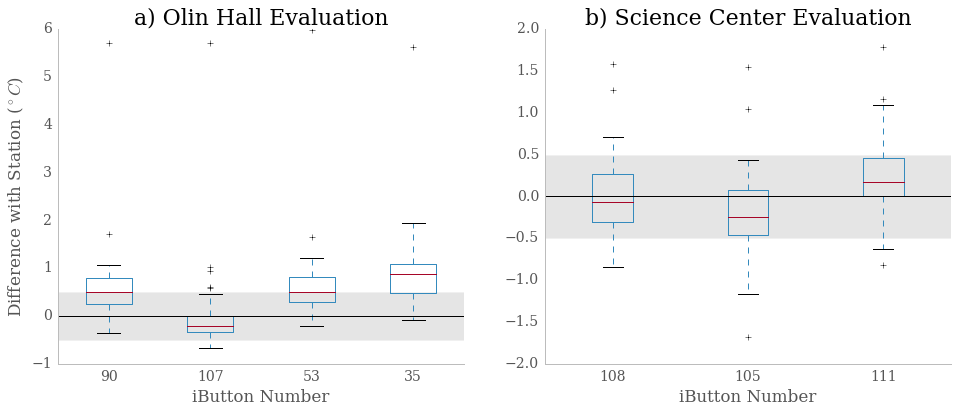

In [6]:
# For T_min 

#startdate = '2015-07-10'
#enddate = '2015-09-15'
fig = plt.figure(figsize=[16,6])
# Olin Hall
plt.subplot(1,2,1)
buttons = [90, 107, 53, 35] #[90, 107, 86, 53, 35, 20]
handle = (tempDF[startdate:enddate].resample('D').min()[buttons].subtract(olinhalldf[startdate:enddate].outTemp.resample('D').min(), axis=0)).boxplot(return_type='axes')
plt.title('a) Olin Hall Evaluation')
plt.xlabel('iButton Number')
plt.ylabel('Difference with Station ($^\circ C$)')
plt.axhline(0, color = 'black')
plt.axhspan(-.5,.5, facecolor='0.8', alpha=0.5)
#plt.ylim([-2,2])
prettify_plot()

# downtown station (Maryland Science Center)
plt.subplot(1,2,2)
buttons = [108, 105, 111] #, 18, 92]
handle = (tempDF[startdate:enddate].resample('D').min()[buttons].subtract(urbandf[startdate:enddate].TEMP.resample('D').min(), axis=0)).boxplot(return_type='axes')
plt.title('b) Science Center Evaluation')
plt.xlabel('iButton Number')
#plt.ylim([-2,2])
plt.axhline(0, color = 'black')
plt.axhspan(-.5,.5, facecolor='0.8', alpha=0.5)

prettify_plot()
#plt.savefig('plots/evaluationboxplot.pdf', dpi = 300)
#print 'number of measurements:', tempDF[startdate:enddate].resample('D').min()[buttons].shape

number of measurements: (63, 3)


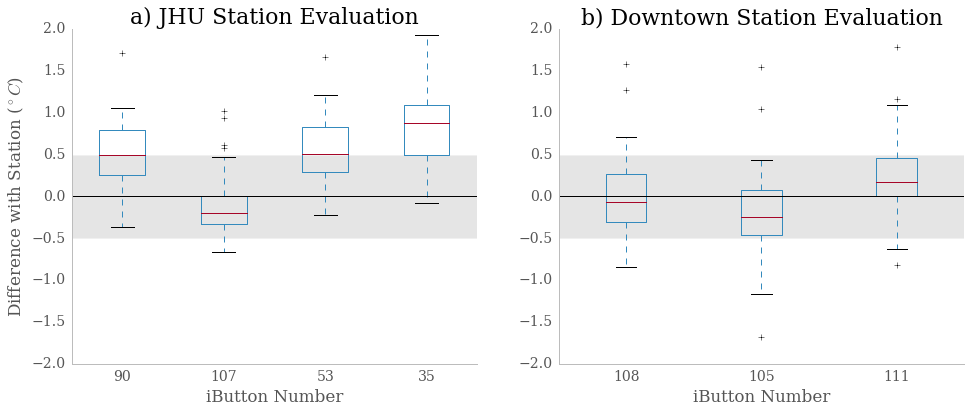

In [7]:
# For T_min 

#startdate = '2015-07-10'
#enddate = '2015-09-15'
fig = plt.figure(figsize=[16,6])
# Olin Hall
plt.subplot(1,2,1)
buttons = [90, 107, 53, 35] #[90, 107, 86, 53, 35, 20]
handle = (tempDF[startdate:enddate].resample('D').min()[buttons].subtract(olinhalldf[startdate:enddate].outTemp.resample('D').min(), axis=0)).boxplot(return_type='axes')
plt.title('a) JHU Station Evaluation')
plt.xlabel('iButton Number')
plt.ylabel('Difference with Station ($^\circ C$)')
plt.axhline(0, color = 'black')
plt.axhspan(-.5,.5, facecolor='0.8', alpha=0.5)
plt.ylim([-2,2])
prettify_plot()

# downtown station (Maryland Science Center)
plt.subplot(1,2,2)
buttons = [108, 105, 111] #, 18, 92]
handle = (tempDF[startdate:enddate].resample('D').min()[buttons].subtract(urbandf[startdate:enddate].TEMP.resample('D').min(), axis=0)).boxplot(return_type='axes')
plt.title('b) Downtown Station Evaluation')
plt.xlabel('iButton Number')
plt.ylim([-2,2])
plt.axhline(0, color = 'black')
plt.axhspan(-.5,.5, facecolor='0.8', alpha=0.5)

prettify_plot()
plt.savefig('plots/evaluationboxplot.pdf', dpi = 300)
print 'number of measurements:', tempDF[startdate:enddate].resample('D').min()[buttons].shape

In [14]:
#Results: compute statistics 
#perform a t-test
from scipy import stats
stats.ttest_ind(tempDF[startdate:enddate][nonparks].resample('D').min().mean().dropna(), 
                #tempDF[startdate:enddate][nonparks].resample('D', how = 'min').mean(), 
                     tempDF[startdate:enddate][parksensors].resample('D').min().mean().dropna(),
                     equal_var = False)

Ttest_indResult(statistic=5.6883149633794492, pvalue=6.7899731064400758e-07)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).min()
  from ipykernel import kernelapp as app


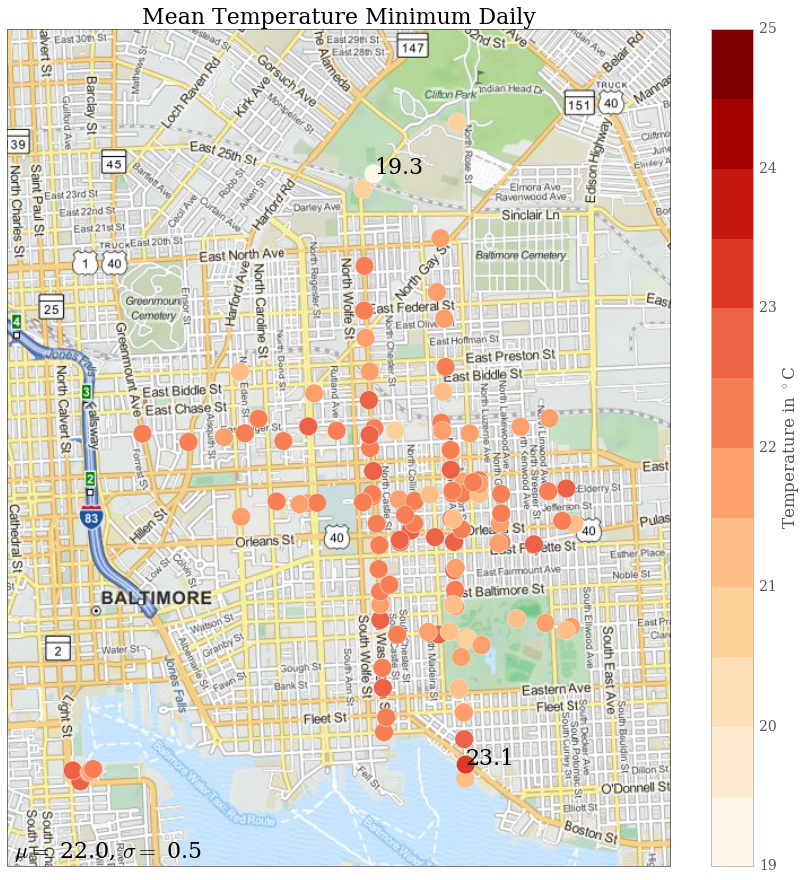

In [9]:
reload(ibuttonplots)
ibuttonplots.mapmean(tempDF[startdate:enddate].resample('D', how = 'min')[selected], meta.loc[selected], name = 'Minimum Daily')

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:28: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).min()
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:31: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).min()
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:35: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).min()
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:39: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).min()
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:57: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).min()
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:58: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).min()
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:59: FutureWarning: how in .resampl

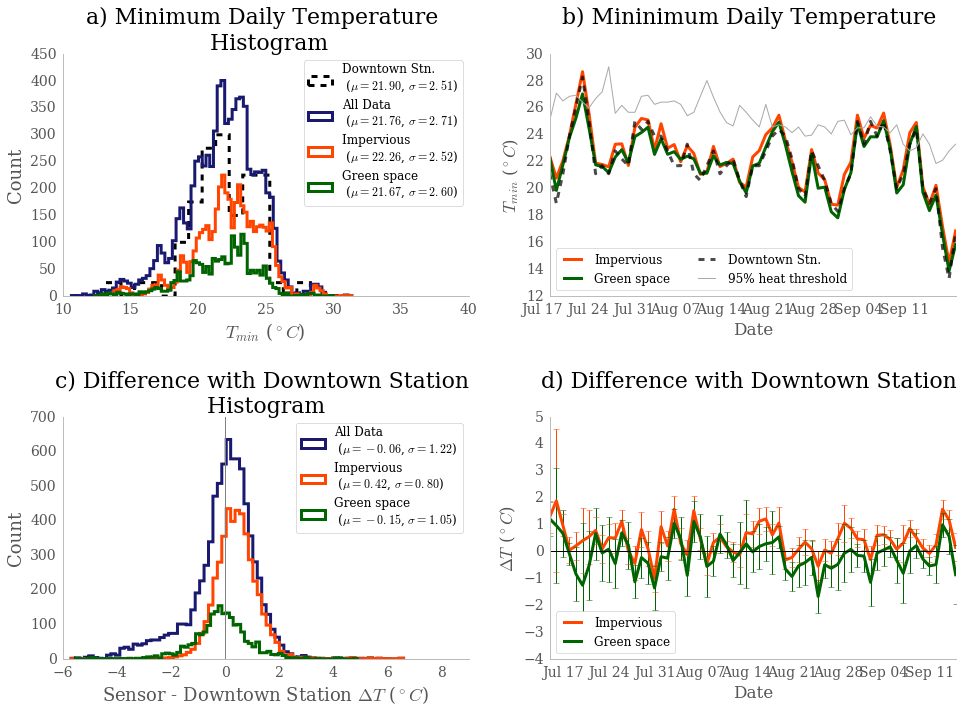

In [17]:
# Histograms plot 

# Compute 95th percentile of temp
# import ulmo
# scicenter = ulmo.ncdc.ghcn_daily.get_data('USW00093784', as_dataframe=True)
# maxT = scicenter['TMAX'].copy()
# minT = scicenter['TMIN'].copy()
# minT.value = minT.value.astype(float)/10. 
# data = minT['value']
# summary = data.groupby(data.index.dayofyear).describe(percentiles =[.90, .95, .98, .99])
# #ninetieth = summary.values[5::10]
# ninetyfifth = summary.values[6::10]
# import numpy as np
# np.save('minT95thpercentileMDSCiCenter.npy', ninetyfifth)
ninetyfifth = np.load('data/minT95thpercentileMDSCiCenter.npy')
#startdate = '2015-07-01' 
import matplotlib.dates as mdates
fig = plt.figure(figsize=[16,12])
M = 75 
purple = 'orangered'#'fuchsia'#'orangered'
green = '#006400'
blue = 'midnightblue' #cyan
#parksensors = np.intersect1d(tempDF.columns, parksensors)
#nonparks = np.intersect1d(tempDF.columns, nonparks)
legendfontsize = 12
ax = fig.add_subplot(221)

data = urbandf[startdate:enddate]['TEMP'].resample('D', how = 'min')
n,bins, patches= ax.hist(data,15, histtype='step', weights= (np.ones(data.shape)*25), linewidth = 3, color = 'black', linestyle=('dashed'), label = 'Downtown Stn. \n ($\mu = %2.2f$, $\sigma = %2.2f$)'%(data.mean(), data.std()))

data = tempDF[startdate:enddate].resample('D', how = 'min').values
data = data[~np.isnan(data)] 
n,bins, patches= ax.hist(data,M, histtype='step', linewidth = 3, color = blue, label = 'All Data \n ($\mu = %2.2f$, $\sigma = %2.2f$)'%(data.mean(), data.std()))

data = tempDF[startdate:enddate][np.intersect1d(tempDF.columns, nonparks)].resample('D', how = 'min').values
data = data[~np.isnan(data)] 
n,bins, patches= ax.hist(data,M, histtype='step', linewidth = 3, color = purple,label = 'Impervious \n ($\mu = %2.2f$, $\sigma = %2.2f$)'%(data.mean(), data.std()))

data = tempDF[startdate:enddate][np.intersect1d(tempDF.columns, parksensors)].resample('D', how = 'min').values
data = data[~np.isnan(data)] 
n,bins, patches= ax.hist(data,M, histtype='step', linewidth = 3, color = green, label = 'Green space \n ($\mu = %2.2f$, $\sigma = %2.2f$)'%(data.mean(), data.std()))

#data = urbandf[startdate:enddate]['TEMP'].resample('D', how = 'min')
#n,bins, patches= ax.hist(data,M, histtype='step', linewidth = 3, color = 'black', label = 'NWS Station ($\mu = %2.2f$, $\sigma = %2.2f$)'%(data.mean(), data.std()))

#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol = 1)
plt.xlim([10, 40])
plt.legend(loc='upper right', fontsize=legendfontsize).get_frame().set_facecolor('white')
plt.title('a) Minimum Daily Temperature \n Histogram', fontsize = 22)
plt.xlabel('$T_{min}$ ($^\circ C$)', fontsize=18)
plt.ylabel('Count', fontsize=18)
prettify_plot()

ax = fig.add_subplot(222)
# plot temp plot 
#minthresh = (np.load('BWImindailytempthresholds.npy') -32) *5/9.
x = tempDF[startdate:enddate].resample('D',how = 'min').index.to_pydatetime()
ax.plot(x,tempDF[startdate:enddate].resample('D', how = 'min')[nonparks].mean(axis=1), purple, label = 'Impervious',  linewidth = 3)
ax.plot(x, tempDF[startdate:enddate].resample('D', how = 'min')[parksensors].mean(axis=1), color = green,label = 'Green space', 
         linewidth = 3)

urbandf[startdate:enddate].resample('D', how = 'min').TEMP.plot(style ='--k', label = 'Downtown Stn.', linewidth = 3, alpha = .7)

#plt.plot(x, minthresh[1][tempDF[startdate:enddate].resample('D', how='min').index.dayofyear-1],
#         color = 'gray', linewidth = 1, label = '95% heat threshold')
plt.plot(x, ninetyfifth[tempDF[startdate:enddate].resample('D', how='min').index.dayofyear-1],
         color = 'darkgray', linewidth = 1, label = '95% heat threshold')
plt.legend(loc='lower left', ncol = 2, fontsize=legendfontsize).get_frame().set_facecolor('white')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.xticks(rotation=0)
plt.title('b) Mininimum Daily Temperature \n')
plt.ylabel('$T_{min}$ ($^\circ C$)')
prettify_plot()

ax = fig.add_subplot(223)
#intra-urban histogram
plt.axvline(0, color ='grey')

diff = tempDF[startdate:enddate].resample('D', how = 'min').subtract(urbandf[startdate:enddate].resample('D', how = 'min').TEMP, axis=0)
data = diff.values
data = data[~np.isnan(data)] 
n,bins, patches= ax.hist(data,M, histtype='step', linewidth = 3,  color = blue, label = 'All Data \n ($\mu = %2.2f$, $\sigma = %2.2f$)'%(data.mean(), data.std()))

data = diff[nonparks].values
data = data[~np.isnan(data)] 
n,bins, patches= ax.hist(data,M, histtype='step', linewidth = 3, color = purple, label = 'Impervious \n ($\mu = %2.2f$, $\sigma = %2.2f$)'%(data.mean(), data.std()))

data = diff[parksensors].values
data = data[~np.isnan(data)] 
n,bins, patches= ax.hist(data,M, histtype='step', linewidth = 3, color = green,label = 'Green space \n ($\mu = %2.2f$, $\sigma = %2.2f$)'%(data.mean(), data.std()))

plt.legend( fontsize=legendfontsize).get_frame().set_facecolor('white')
plt.xlabel('$\Delta T_{u}$ ($^\circ C$)', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.legend(fontsize=legendfontsize).get_frame().set_facecolor('white')
plt.title('c) Difference with Downtown Station \n Histogram ', fontsize = 22)
plt.xlabel('Sensor - Downtown Station $\Delta T$ ($^\circ C$)', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.xlim([-6,9])
prettify_plot()

ax = fig.add_subplot(224)
plt.errorbar(diff.index, diff[nonparks].mean(axis=1), yerr = diff[nonparks].std(axis=1), color = purple)
plt.plot(diff.index, diff[nonparks].mean(axis=1), 
         label = 'Impervious',
         linewidth = 3, color = purple)
plt.errorbar(diff.index, diff[parksensors].mean(axis=1),yerr = diff[parksensors].std(axis=1),
    linewidth = 1, color = green)
plt.plot(diff.index, diff[parksensors].mean(axis=1), label = 'Green space', linewidth = 3,  
         color = green)
plt.axhline(0, color ='k')
lgd = plt.legend(selected, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol = 2, fontsize=legendfontsize)
plt.legend(fontsize=legendfontsize, loc = 'lower left').get_frame().set_facecolor('white')
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol = 1)
plt.title('d) Difference with Downtown Station \n')
plt.ylabel('$\Delta T$ ($^\circ C$)')
#plt.text('2015-07-15', -2.5, '$ \mu_{Green} = %2.2f$'%diff[parksensors].mean(axis=1).mean(), 
#         fontsize = 18)
#plt.text('2015-07-15', -3.5, '$ \mu_{Imperv} = %2.2f$'%diff[nonparks].mean(axis=1).mean(), 
#         fontsize = 18)
plt.ylim([-4,5])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
prettify_plot()
plt.xlabel('Date')
#ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)

#plt.savefig('plots/histogramtimeseries.eps', dpi = 300)
#plt.savefig('plots/histogramtimeseries.pdf', dpi = 300)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).min()
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).min()
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:27: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()


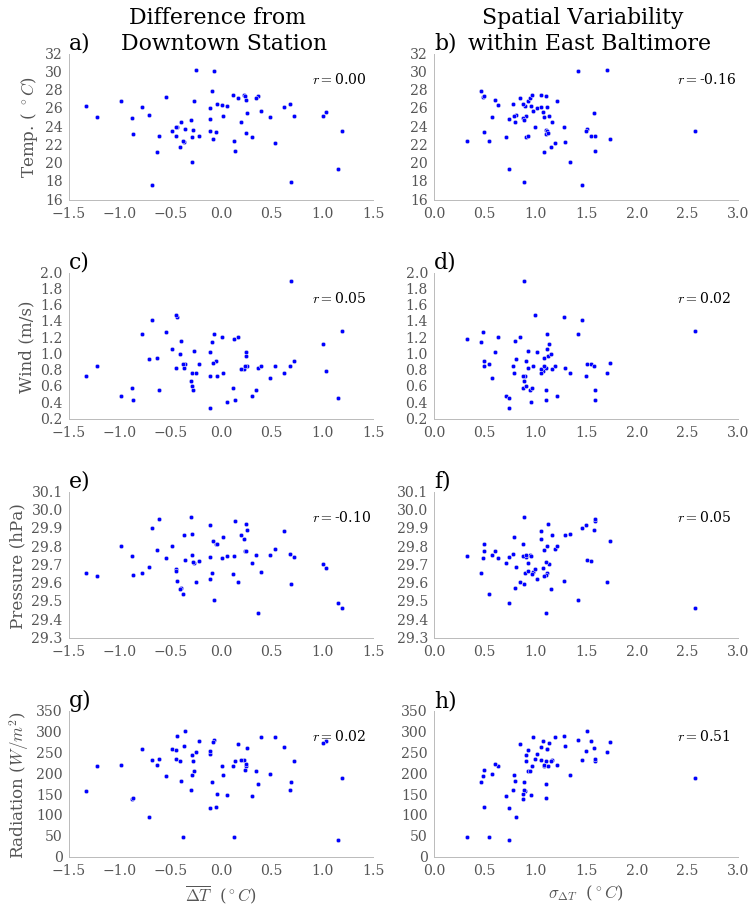

In [18]:
import string

#startdate = '2015-06-15'
#UHI =  tempDF[startdate:enddate].resample('D', how = 'min')-ruraldf[startdate:enddate].resample('D', how = 'min').TEMP
#UHI = UHI.mean(axis=1)
Intra =  tempDF[startdate:enddate].resample('D', how = 'min').subtract(urbandf[startdate:enddate].resample('D', how = 'min').TEMP, axis=0)#tempDF[startdate:enddate].resample('D', how = 'min')-urbandf[startdate:enddate].resample('D', how = 'min').TEMP
IntraStd = Intra.std(axis=1)
Intra = Intra.mean(axis=1)
MeanTemp = tempDF[startdate:enddate].resample('D', how = 'min').mean(axis=1)
units = {'outTemp':' $^\circ C$', 'windSpeed': 'm/s', 'pressure': 'hPa', 'radiation': '$W/m^2$'}
nameDict= {'outTemp': 'Temp.', 'windSpeed': 'Wind', 'pressure': 'Pressure', 'radiation': 'Radiation'}
n = 1
fig1 = plt.figure(figsize=[12,14.4])
for variable in ['outTemp', 'windSpeed', 'pressure', 'radiation']: 
    plt.subplot(4,2,n)
    try: 
#         x = olinhalldf[startdate:enddate][variable].resample('D', how= 'mean')
#         r = np.corrcoef(MeanTemp[1:],x[0:-1])[0,1]
#         plt.scatter(MeanTemp[1:],x[0:-1])
#         plt.ylabel('Mean '+ variable + ' (' + units[variable]+ ')')
#         #plt.xlabel('Difference with Station $\Delta T_{min}$')
#         plt.annotate('$r=$%.2f'%r,xy=(.8, .8), xycoords ='axes fraction')
#         #plt.legend(['$r=$%.2f'%np.corrcoef(Intra[1:],x[0:-1])[0,1]], loc ='upper left').get_frame().set_facecolor('white')
#         prettify_plot()
        
        plt.subplot(4,2,n)
        x = olinhalldf[startdate:enddate][variable].resample('D', how= 'mean')
        r = np.corrcoef(Intra[1:],x[0:-1])[0,1]
        plt.scatter(Intra[1:],x[0:-1])
        plt.ylabel(nameDict[variable] + ' (' + units[variable]+ ')')
        #plt.xlabel('Difference with Station $\Delta T_{min}$')
        plt.annotate('$r=$%.2f'%r,xy=(.8, .8), xycoords ='axes fraction')
        plt.title(string.ascii_lowercase[n-1] + ')', loc='left')
        #plt.legend(['$r=$%.2f'%np.corrcoef(Intra[1:],x[0:-1])[0,1]], loc ='upper left').get_frame().set_facecolor('white')
        prettify_plot()
        
        plt.subplot(4,2,n+1)
        r = np.corrcoef(IntraStd[1:],x[0:-1])[0,1]
        plt.scatter(IntraStd[1:],x[0:-1])
        #plt.ylabel('Mean %s'%variable)
        #plt.xlabel('Std. Dev. of Difference with Station')
        #plt.legend(['$r=$%.2f'%np.corrcoef(IntraStd[1:],x[0:-1])[0,1]], loc ='upper left').get_frame().set_facecolor('white')                
        plt.title(string.ascii_lowercase[n] + ')', loc='left')
        plt.annotate('$r=$%.2f'%r,xy=(.8, .8), xycoords ='axes fraction')
        prettify_plot()

#         plt.scatter(UHI[1:],x[0:-1])
#         plt.ylabel('Mean %s'%variable)
#         plt.xlabel('UHI $\Delta T_{min}$')
#         plt.legend(['$r=$%.2f'%np.corrcoef(UHI[1:],x[0:-1])[0,1]], loc ='upper left').get_frame().set_facecolor('white')
#         prettify_plot()
        
    except IndexError: 
                print 'error: cannot map %s'%variable
    except KeyError : 
            print 'error: cannot map %s'%variable    
    #n = n+1
    n= n+2

plt.subplot(4,2,7)    
plt.xlabel('$\overline{\Delta T}$  ($^\circ C$)')

plt.subplot(4,2,8)    
plt.xlabel('$\sigma_{\Delta T}$  ($^\circ C$)')

plt.subplot(4,2,1)    
plt.title('Difference from \n Downtown Station')

plt.subplot(4,2,2)    
plt.title('Spatial Variability \n within East Baltimore')
plt.savefig('plots/timescatterplot.pdf', dpi = 300)    

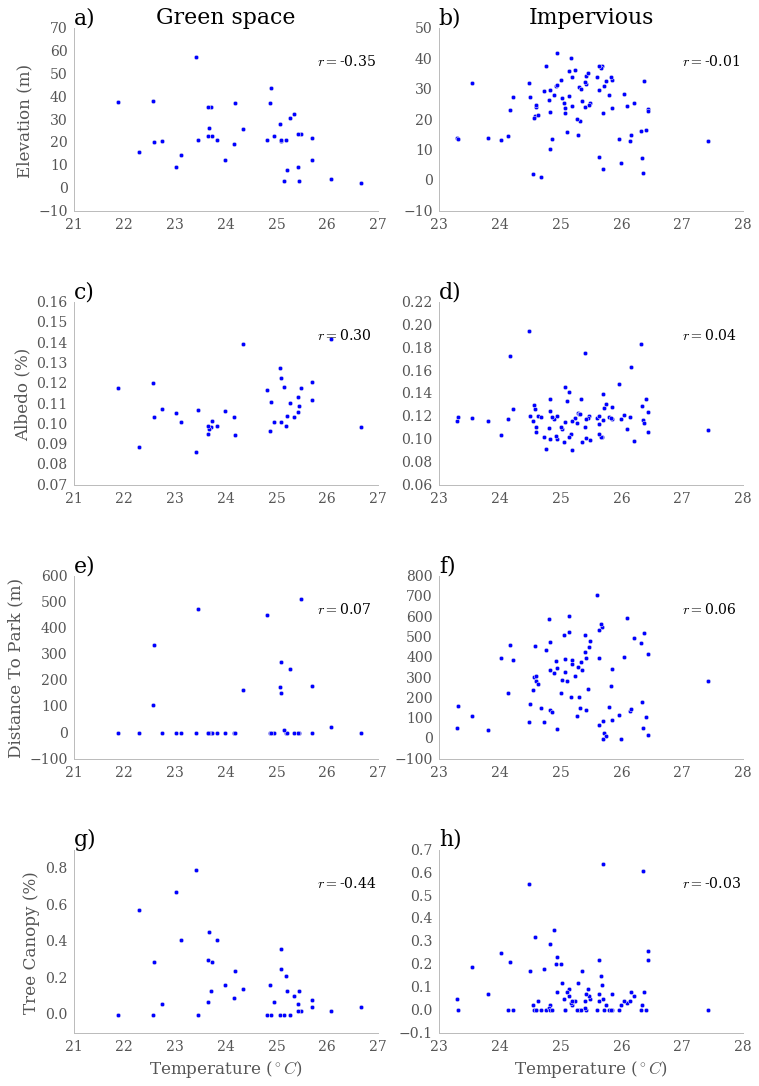

In [27]:
# figure 8
# compute possible co-variates for regression with mean temeprature
import spatialfunctions
lon = meta['location:Longitude'][selected].values
lat = meta['location:Latitude'][selected].values

feature_file = 'data/Parks_Dissolved_reproj.shp'
distance_to_park = spatialfunctions.compute_distance_to_feature(lon,lat,feature_file, feature_name = 'none')

rasterfile = 'data/BaltimoreDEM'
elevation = spatialfunctions.extract_raster_values(lon,lat, rasterfile)

# compute LST
#rasterfile ='../satellite/LC80150332015229LGN00_B10.TIF' 
#band10 = spatialfunctions.extract_raster_values(lon,lat, rasterfile)
#LST = spatialfunctions.band10_toLST(band10)
rasterfile = 'data/atm_cor_10_LC80150332015229.tif'
LST = spatialfunctions.extract_raster_values(lon,lat, rasterfile)

# compute tree canopy cover 
rasterfile = 'data/TreeBaltimore_CanopyCover.img'
tree_cover = spatialfunctions.extract_raster_values(lon,lat, rasterfile)
tree_cover20ft = spatialfunctions.extract_raster_values(lon, lat, rasterfile,2,2, how = 'density')
tree_cover50ft = spatialfunctions.extract_raster_values(lon, lat, rasterfile,5,5, how = 'density')
tree_cover100ft = spatialfunctions.extract_raster_values(lon, lat, rasterfile,10,10, how = 'density')
tree_cover500ft = spatialfunctions.extract_raster_values(lon, lat, rasterfile,50,50, how = 'density')
tree_cover = spatialfunctions.extract_raster_values(lon,lat, rasterfile)

# Compute albedo 
path = 'data/LC80150332015229LGN00/'
B = np.zeros((5,lon.shape[0]))
# Import bands and convert to reflectance 
for i in (1,2,3,4,5): 
    file = path+ 'LC80150332015229LGN00_B'+'%s'%i +'.TIF'
    DN = spatialfunctions.extract_raster_values(lon,lat,file)
    # convert from digital number to toa reflectance  using : rho*\lambda = REFLECTANCE_MULT_BAND_x*DN +REFLECTANCE_ADD_BAND_x
    reflectance_mult_band = 2.000e-5
    reflectance_add_band  = -0.100000
    B[i-1, :] = reflectance_mult_band*DN+reflectance_add_band

alb = spatialfunctions.albedo(B[0,:], B[1,:], B[2,:], B[3,:], B[4,:], )
alb[alb>1] = 'NaN'
alb[alb<0] = 'NaN'
mean_temp = tempDF[selected].mean()

# separate sensors into types 
ebaltsensorsi = np.where(meta['location:Longitude']>= -76.6125831)#-76.61)# -76.6072591 )
parksi = np.where((meta['landcoverclass'] != 'impervious') & (meta['location:Longitude']>= -76.6125831)) # -76.61) )

parksensors = meta.index[parksi]#meta.sensornumber.iloc[parksi]
ebaltsensors = meta.index[ebaltsensorsi]# meta.sensornumber.iloc[ebaltsensorsi]
nonparks = np.setdiff1d(ebaltsensors, parksensors)

##### Compute mon-parks data 
nn = np.intersect1d(selected,nonparks)
indices = np.zeros(nn.shape)
i = 0
for n in nn: 
    indices[i] = np.where(selected == n)[0]
    i = i+1
indices = indices.astype(int)
nonparks_selected = np.intersect1d(nonparks, selected[indices])

nonparkdf = pd.DataFrame({"AirTemp":  mean_temp.loc[nonparks_selected], "Elevation": elevation[indices], 
                   "LST": LST[indices], "Distance To Park": distance_to_park[indices], 
                   "Albedo": alb[indices], #"inPark":parkyesno[indices], 
                  #"trees10ft": tree_cover[indices],# "trees20ft": tree_cover20ft[indices], "trees50ft": tree_cover50ft[indices], 
                   "Tree Canopy": tree_cover100ft[indices],# "trees500ft": tree_cover500ft[indices]
                         })

##### Compute parks data 
nn = np.intersect1d(selected,parksensors)
indices = np.zeros(nn.shape)
i = 0
for n in nn: 
    indices[i] = np.where(selected == n)[0]
    i = i+1
indices = indices.astype(int)
parks_selected = np.intersect1d(parksensors.values, selected[indices])

parkdf = pd.DataFrame({"AirTemp":  mean_temp.loc[parks_selected], "Elevation": elevation[indices], 
                   "LST": LST[indices], "Distance To Park": distance_to_park[indices], 
                   "Albedo": alb[indices], #"inPark":parkyesno[indices], 
                  #"trees10ft": tree_cover[indices], "trees20ft": tree_cover20ft[indices], "trees50ft": tree_cover50ft[indices], 
                   "Tree Canopy": tree_cover100ft[indices], #"trees500ft": tree_cover500ft[indices]
                      })


parkdf.corr()

###### plot 
import string
plt.figure(figsize=[12,18])
n = 1
units = {'Elevation': 'm', 'LST': '$^\circ C$', 'Albedo': '%', 'Distance To Park': 'm', 'Tree Canopy': '%'}

for variable in ['Elevation', 'Albedo', 'Distance To Park', 'Tree Canopy']: # parkdf.columns: 
    r = np.corrcoef(parkdf['AirTemp'], parkdf[variable])[0,1]
    plt.subplot(4,2,n)
    plt.scatter(parkdf['AirTemp'], parkdf[variable])
    #plt.legend(['$r=$%.2f'%r])
    plt.annotate('$r=$%.2f'%r, xy=(.8, .8), xycoords ='axes fraction')
    plt.ylabel(variable + ' (' + units[variable]+ ')')
    plt.title(string.ascii_lowercase[n-1] + ')', loc='left')
    prettify_plot()
    
    plt.subplot(4,2,n+1)
    r = np.corrcoef(nonparkdf['AirTemp'], nonparkdf[variable])[0,1]
    plt.scatter(nonparkdf['AirTemp'], nonparkdf[variable])
    plt.title(string.ascii_lowercase[n] + ')', loc='left')
    #plt.legend(['$r=$%.2f'%r])
    plt.annotate('$r=$%.2f'%r,xy=(.8, .8), xycoords ='axes fraction')
    
    prettify_plot()

    n = n+2  
    
plt.subplot(4,2,7)
plt.xlabel('Temperature ($^\circ C$)')  
plt.subplot(4,2,8)
plt.xlabel('Temperature ($^\circ C$)')    

plt.subplot(4,2,1)
plt.title('Green space')

plt.subplot(4,2,2)
plt.title('Impervious')
plt.savefig('plots/geographiccorrelations.pdf', dpi = 300)

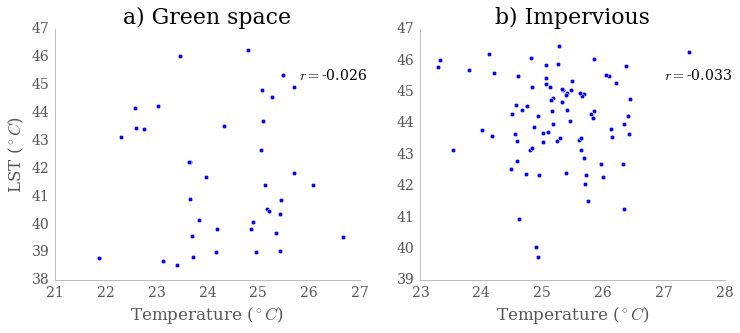

In [26]:
variable = 'LST'
plt.figure(figsize=[12,4.5])
m = 2# number of rows
r = np.corrcoef(parkdf['AirTemp'], parkdf[variable])[0,1]
plt.subplot(1,2,1)
plt.scatter(parkdf['AirTemp'], parkdf[variable])
#plt.legend(['$r=$%.2f'%r])
plt.annotate('$r=$%.3f'%r, xy=(.8, .8), xycoords ='axes fraction')
plt.ylabel(variable + ' (' + units[variable]+ ')')
prettify_plot()

plt.subplot(1,2,2)
r = np.corrcoef(nonparkdf['AirTemp'], nonparkdf[variable])[0,1]
plt.scatter(nonparkdf['AirTemp'], nonparkdf[variable])
#plt.legend(['$r=$%.2f'%r])
plt.annotate('$r=$%.3f'%r,xy=(.8, .8), xycoords ='axes fraction')

prettify_plot()
    
plt.subplot(1,2,1)
plt.xlabel('Temperature ($^\circ C$)')  
plt.subplot(1,2,2)
plt.xlabel('Temperature ($^\circ C$)')    

plt.subplot(1,2,1)
plt.title('a) Green space')

plt.subplot(1,2,2)
plt.title('b) Impervious')
plt.savefig('plots/lstvstair.pdf', dpi = 300)

In [29]:
df = pd.DataFrame({"AirTemp": mean_temp, "Elevation": elevation, 
                   "LST": LST, "park_distance": distance_to_park, 
                   "albedo": alb, 
                  #"trees10ft": tree_cover, #"trees20ft": tree_cover20ft, "trees50ft": tree_cover50ft, 
                   "trees100ft": tree_cover100ft, #"trees500ft": tree_cover500ft
                  })
df.corr()

,AirTemp,Elevation,LST,albedo,park_distance,trees100ft
AirTemp,1.000000,-0.128997,0.207403,0.230066,0.258402,-0.315205
Elevation,-0.128997,1.000000,-0.001215,-0.177428,0.228900,0.046396
LST,0.207403,-0.001215,1.000000,0.156136,0.599116,-0.329674
albedo,0.230066,-0.177428,0.156136,1.000000,0.147713,-0.167053
park_distance,0.258402,0.228900,0.599116,0.147713,1.000000,-0.267347
trees100ft,-0.315205,0.046396,-0.329674,-0.167053,-0.267347,1.000000


In [30]:
import statsmodels.formula.api as sm
inPark = {'grass': 1, 'impervious': 0, 'dirt':1, 'grass impervious':0, 'grass impervious dirt': 0 }
parkyesno = np.array([inPark[x] for x in meta.loc[selected].landcoverclass])
df['InPark'] = parkyesno

result = sm.ols(formula="AirTemp ~ Elevation + C(InPark)", data=df).fit()
print result.params
print result.summary()

Intercept         25.573642
C(InPark)[T.1]    -1.035048
Elevation         -0.013064
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                AirTemp   R-squared:                       0.242
Model:                            OLS   Adj. R-squared:                  0.229
Method:                 Least Squares   F-statistic:                     18.79
Date:                Mon, 27 Jun 2016   Prob (F-statistic):           8.26e-08
Time:                        11:44:44   Log-Likelihood:                -152.63
No. Observations:                 121   AIC:                             311.3
Df Residuals:                     118   BIC:                             319.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------

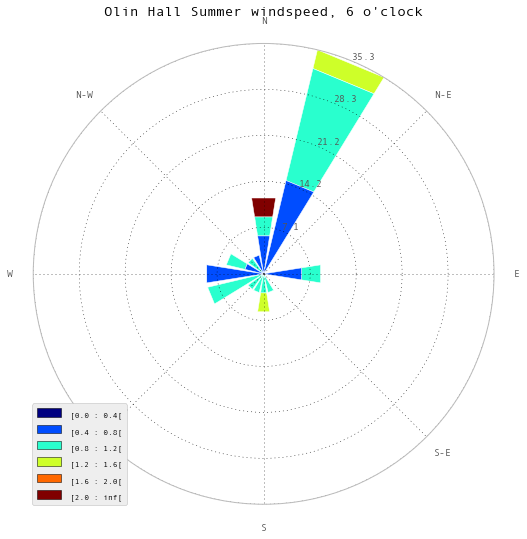

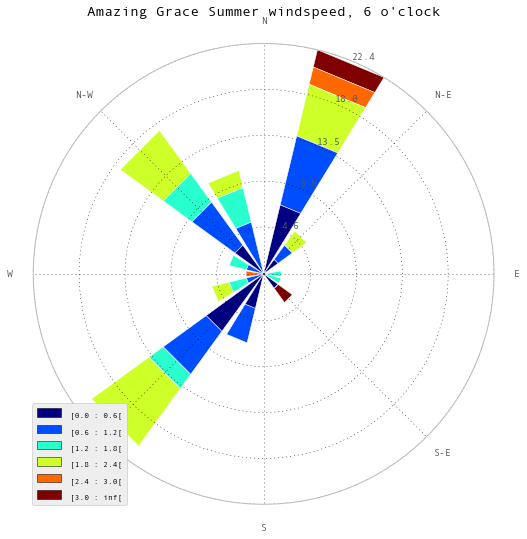

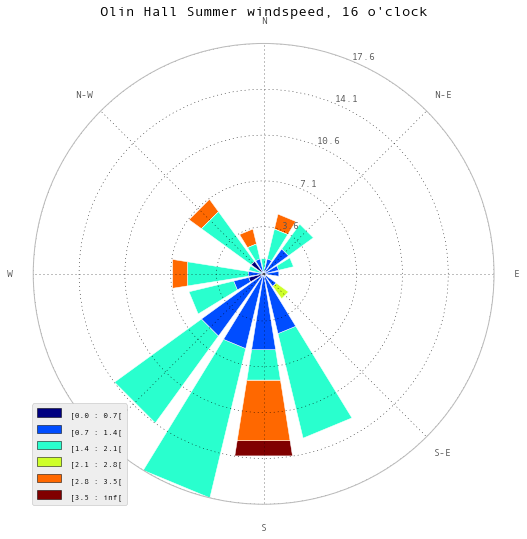

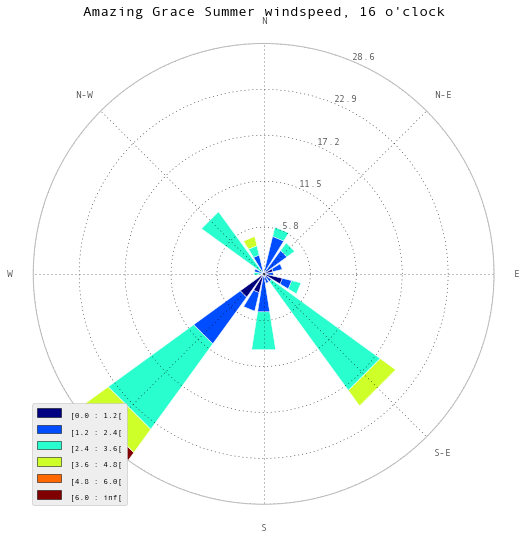

In [3]:
from windrose import WindroseAxes
startdate = '2015-06-24' 
enddate = '2015-09-25'
hour = 6

print olinhalldf[olinhalldf.index.hour==6][startdate:enddate].windSpeed.mean() 

ax = WindroseAxes.from_ax()
ax.bar(olinhalldf[olinhalldf.index.hour==hour][startdate:enddate].windDir, olinhalldf[olinhalldf.index.hour==hour][startdate:enddate].windSpeed, normed=True, opening=0.8, edgecolor='white')
ax.set_legend()
plt.title('Olin Hall Summer windspeed, %i o\'clock'%hour)

ax = WindroseAxes.from_ax()
ax.bar(amazinggracedf[amazinggracedf.index.hour==hour][startdate:enddate].windDir, 
       amazinggracedf[amazinggracedf.index.hour==hour][startdate:enddate].windSpeed, normed=True, opening=0.8, edgecolor='white')
ax.set_legend()
plt.title('Amazing Grace Summer windspeed, %i o\'clock'%hour)

hour = 16
ax = WindroseAxes.from_ax()
ax.bar(olinhalldf[olinhalldf.index.hour==hour][startdate:enddate].windDir, olinhalldf[olinhalldf.index.hour==hour][startdate:enddate].windSpeed, normed=True, opening=0.8, edgecolor='white')
ax.set_legend()
plt.title('Olin Hall Summer windspeed, %i o\'clock'%hour)

ax = WindroseAxes.from_ax()
ax.bar(amazinggracedf[amazinggracedf.index.hour==hour][startdate:enddate].windDir, 
       amazinggracedf[amazinggracedf.index.hour==hour][startdate:enddate].windSpeed, normed=True, opening=0.8, edgecolor='white')
ax.set_legend()
plt.title('Amazing Grace Summer windspeed, %i o\'clock'%hour)

for variable in ['outTemp', 'windSpeed', 'pressure', 'outHumidity', 'radiation', 'windDir']:
    diff = amazinggracedf[startdate:enddate][variable].resample('D', how= 'mean') - olinhalldf[startdate:enddate][variable].resample('D', how= 'mean')
    print variable, diff.mean()

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: .resample() is now a deferred operation
use .resample(...).mean() instead of .resample(...)
  from ipykernel import kernelapp as app


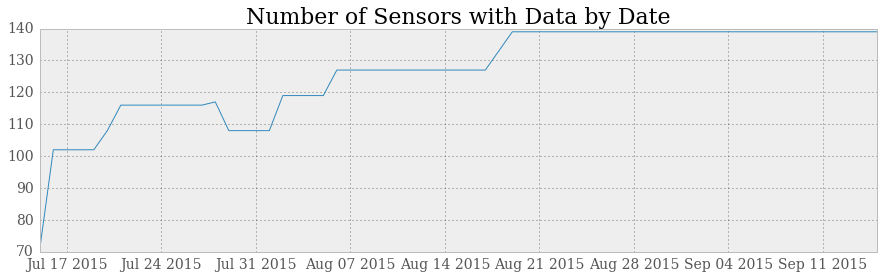

In [31]:
plt.figure(figsize=[15,4])
n = (~np.isnan(tempDF[startdate:enddate].resample('D'))).sum(axis=1)
plt.plot(n)
plt.title('Number of Sensors with Data by Date')

In [211]:
startdate = '2015-07-21'
print 'Downtown Station Mean', urbandf[startdate:enddate].TEMP.resample('D', how = 'min').mean()
#print 'BWI mean', df[startdate:enddate].TEMP.resample('D', how = 'min').mean()
print 'Olin Hall mean', olinhalldf[startdate:enddate].outTemp.resample('D', how = 'min').mean()
print 'Amazing Grace mean', amazinggracedf[startdate:enddate].outTemp.resample('D', how = 'min').mean()

Downtown Station Mean 21.7578947368
Olin Hall mean 18.7358674464
Amazing Grace mean 21.1744639376


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).min()
  from ipykernel import kernelapp as app
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).min()
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).min()


In [212]:
tempDF[startdate:enddate].resample('D').min().mean().to_clipboard()

In [214]:
tempDF[startdate:enddate].resample('D').min().mean().max()

22.950701754385967

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).min()
  from ipykernel import kernelapp as app


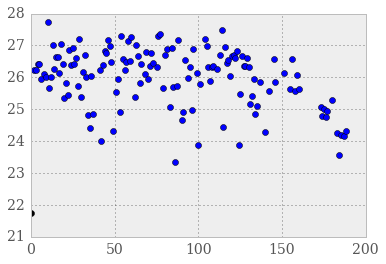

In [209]:
plt.plot(tempDF[startdate:enddate].mean(), 'o', color = 'blue')
plt.plot(urbandf[startdate:enddate].TEMP.resample('D', how = 'min').mean(), 'o', color = 'black')